Data come from the National Hurricane Center's Data Archive: https://www.nhc.noaa.gov/data/#hurdat

[2017 Hurricane Talk](http://www.csuchico.edu/geos/stories/17.09.14_HurricaneTalk.shtml)

where
[Dr. Ann Bykerk-Kauffman](http://www.csuchico.edu/%7eabykerk-kauffman/)

gave a talk and Dr. David M. Hassenzahl Dean of the [College of Natural Sciences](https://www.csuchico.edu/nsci/index.shtml) 

In [118]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import bplot as bp
import datetime
import pystan
import stan_utility
import requests
%matplotlib inline

/Users/ez/py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/roualdes/stormevents/master/data.csv')

In [5]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.drop_duplicates('name', inplace=True)
df = df.loc[df.date > pd.to_datetime('1915'), :].copy()
df['year'] = df.date.dt.year                                                         
df['day'] = df.date.dt.day                                                           
df['peak'] = df.groupby('year')['date'].transform(lambda x: x.mode()[0])             
df['diff'] = df.apply(lambda x: np.abs((x.date - x.peak).days), axis=1)

Counts by month

In [184]:
df['date'].dt.month.value_counts().sort_index()

1       5
2       1
3       1
4       5
5      71
6     220
7     379
8     582
9     679
10    369
11     96
12     14
Name: date, dtype: int64

Density by month

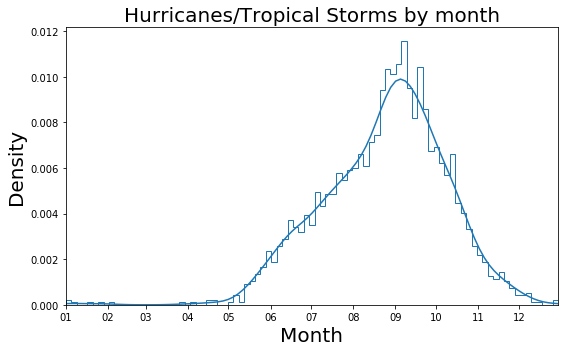

In [14]:
dates = mdates.date2num([datetime.datetime(2018, d.month, d.day)                     
                         for _, d in df['date'].dropna().iteritems()])                                                                                                                                       
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.density(dates)       
bp.histogram(dates, bins=365//4)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Density', fontsize=20)      
plt.title('Hurricanes/Tropical Storms by month', fontsize=20)
ax.set_xlim([dates.min(), dates.max()])  
ax.xaxis.set_major_locator(mdates.AutoDateLocator())                                 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))                             
plt.tight_layout()

Prep data

In [15]:
sdf = (df.groupby('year', as_index=False)
            .aggregate(lambda x: np.std(x, ddof=1)))
sdata = {                                                                            
    'T': sdf.shape[0],                                                               
    'y': sdf['diff'].values.ravel(),                                                 
}

Look at data

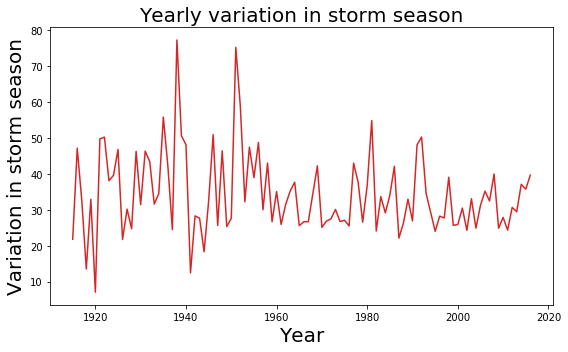

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['diff'], color='tab:red')
plt.xlabel('Year', fontsize=20)
plt.ylabel('Variation in storm season', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

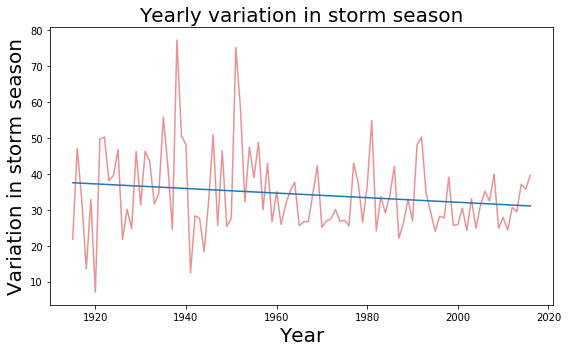

In [142]:
reg = sm.OLS(sdf['diff'], sm.tools.add_constant(sdf['year'])).fit()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['diff'], color='tab:red', alpha=0.5)
bp.line(sdf['year'], reg.fittedvalues)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Variation in storm season', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

In [143]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.823
Date:                Wed, 06 Jun 2018   Prob (F-statistic):             0.0960
Time:                        20:04:32   Log-Likelihood:                -391.35
No. Observations:                 102   AIC:                             786.7
Df Residuals:                     100   BIC:                             791.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        160.1874     74.915      2.138      0.0

In [19]:
#local_linear = requests.get('https://raw.githubusercontent.com/roualdes/stormevents/master/local_linear.stan').text
with open('/Users/ez/stormevents/local_linear.stan', 'r') as ll:
    local_linear = ll.read()
print(local_linear)

data {
  int <lower=0> T;
  vector[T] y;
}
transformed data {
  real sd_y = sd(y);
}
parameters {
  vector[T] u_err;
  real<lower=0> u_tau;

  vector[T] v_err;
  // real<lower=0> v_tau;

  real<lower=0> y_err;
}
transformed parameters {
  vector[T] u;
  vector[T] v;

  u[1] = y[1] + u_tau * u_err[1];
  v[1] = v_err[1];
  for (t in 2:T) {
    u[t] = u[t-1] + v[t-1] + u_tau * u_err[t-1];
    // v[t] = v[t-1] + v_tau * v_err[t-1];
    v[t] = v[t-1] + v_err[t-1];
  }
}
model {
  // priors
  v_err ~ normal(0, 1);
  // v_tau ~ exponential(16 / sd_y);
  // v_tau ~ normal(0, sd_y / 16);
  // v_tau ~ normal(0, 1);
  
  u_err ~ normal(0, 1);
  // u_tau ~ exponential(4 / sd_y);
  // u_tau ~ normal(0, sd_y / 4);
  u_tau ~ normal(0, 10);

  // y_err ~ normal(0, 2.5 * sd_y);
  y_err ~ exponential(1 / sd_y);

  // likelihood
  y ~ normal(u, y_err);
}
generated quantities {
  vector[T] y_pred;
  for (t in 1:T)
    y_pred[t] = normal_rng(u[t], y_err);
}



In [20]:
sm = pystan.StanModel(model_code=local_linear)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dc291256bcff0050dfed9f83aa43b2d4 NOW.


In [25]:
sfit = sm.sampling(data=sdata, control={'max_treedepth': 20})                                                                                                                                    
posterior = sfit.extract()  

/Users/ez/py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


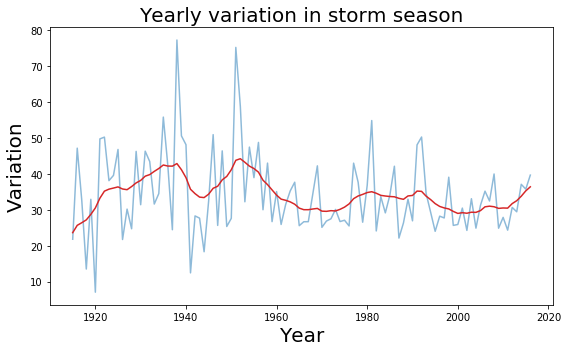

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()                                                                         
bp.curve(sdf['year'], sdf['diff'], alpha=0.5)                                                   
bp.curve(sdf['year'], posterior['y_pred'].mean(0), color='tab:red')                  
plt.ylabel('Variation', fontsize=20)                                                              
plt.xlabel('Year', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

In [90]:
stan_utility.check_treedepth(sfit, max_depth=20)
stan_utility.check_energy(sfit)
stan_utility.check_div(sfit)

0 of 4000 iterations saturated the maximum tree depth of 20 (0.0%)
E-BFMI indicated no pathological behavior
0.0 of 4000 iterations ended with a divergence (0.0%)


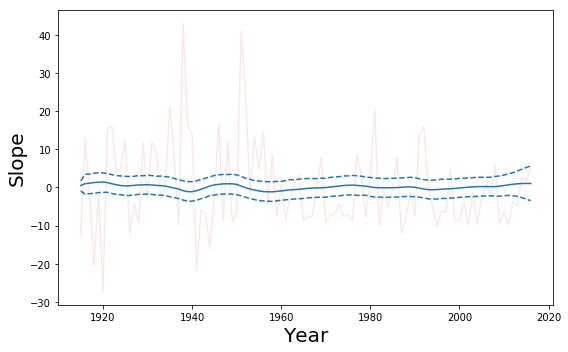

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['diff'] - sdf['diff'].mean(), color='tab:red', alpha=0.1)
bp.curve(sdf['year'], np.percentile(posterior['v'],  [2.5], axis=0)[0], linestyle='--')
bp.curve(sdf['year'], np.percentile(posterior['v'], [97.5], axis=0)[0], linestyle='--')
bp.curve(sdf['year'], posterior['v'].mean(axis=0))
plt.xlabel('Year', fontsize=20)
plt.ylabel('Slope', fontsize=20)
plt.tight_layout()

In [150]:
print(np.any(np.percentile(posterior['v'], [5], axis=0) > 0))
print(np.any(np.percentile(posterior['v'], [95], axis=0) < 0))

False
False
